In [2]:
import os 
import numpy as np
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten , Activation ,BatchNormalization
try:
    from keras.preprocessing.image import ImageDataGenerator
except ImportError:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models,layers 
try:
    from keras.utils.np_utils import to_categorical
except ImportError:
    try:
        from keras.utils import to_categorical
    except ImportError:
        from tensorflow.keras.utils import to_categorical
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import matplotlib.pyplot as plt

In [6]:
# ============================================
# Fingerprint Image Preprocessing Pipeline
# ============================================
# Features:
# 1. Histogram Equalization
# 2. Gaussian Blur Denoising (Optional)
# 3. Resize to Fixed Size
# 4. Normalize Pixel Values
# 5. Save Processed Images to New Folder

import os
import cv2
import numpy as np
from pathlib import Path
import shutil

# Configuration Parameters
SOURCE_DIR = 'Project-Data'  # Source data directory
OUTPUT_DIR = 'Project-Data-Processed'  # Output directory for processed data
TARGET_SIZE = (90, 90)  # Target image size (height, width)
APPLY_GAUSSIAN_BLUR = False  # Whether to apply Gaussian blur (usually not recommended as it blurs details)
GAUSSIAN_KERNEL_SIZE = (3, 3)  # Gaussian blur kernel size
APPLY_HISTOGRAM_EQ = True  # Whether to apply histogram equalization
NORMALIZE_PIXELS = True  # Whether to normalize pixel values to [0, 1]

def preprocess_fingerprint_image(img, apply_hist_eq=True, apply_blur=False, 
                                  blur_kernel=(3, 3), normalize=True):
    """
    Preprocess a single fingerprint image
    
    Parameters:
        img: Input image (numpy array)
        apply_hist_eq: Whether to apply histogram equalization
        apply_blur: Whether to apply Gaussian blur
        blur_kernel: Gaussian blur kernel size
        normalize: Whether to normalize pixel values to [0, 1]
    
    Returns:
        processed_img: Processed image
    """
    # Ensure grayscale image
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. Gaussian blur denoising (optional, usually not recommended as it loses details)
    if apply_blur:
        img = cv2.GaussianBlur(img, blur_kernel, 0)
    
    # 2. Histogram equalization - enhance contrast
    if apply_hist_eq:
        img = cv2.equalizeHist(img)
    
    # 3. Normalize pixel values to [0, 1]
    if normalize:
        img = img.astype(np.float32) / 255.0
    else:
        img = img.astype(np.uint8)
    
    return img

def process_directory(source_dir, output_dir, subfolder_name, 
                      target_size=TARGET_SIZE, apply_hist_eq=APPLY_HISTOGRAM_EQ,
                      apply_blur=APPLY_GAUSSIAN_BLUR, normalize=NORMALIZE_PIXELS):
    """
    Process all images in a directory
    
    Parameters:
        source_dir: Source directory path
        output_dir: Output directory path
        subfolder_name: Subfolder name (train/validate/test)
        target_size: Target image size
        apply_hist_eq: Whether to apply histogram equalization
        apply_blur: Whether to apply Gaussian blur
        normalize: Whether to normalize pixel values
    """
    source_path = os.path.join(source_dir, subfolder_name)
    output_path = os.path.join(output_dir, subfolder_name)
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    # Get all image files
    image_files = glob.glob(os.path.join(source_path, '*.bmp'))
    if len(image_files) == 0:
        image_files = glob.glob(os.path.join(source_path, '*.jpg'))
    if len(image_files) == 0:
        image_files = glob.glob(os.path.join(source_path, '*.png'))
    
    print(f"\nProcessing {subfolder_name} directory...")
    print(f"  Source directory: {source_path}")
    print(f"  Output directory: {output_path}")
    print(f"  Found {len(image_files)} image files")
    
    processed_count = 0
    failed_count = 0
    
    for img_file in image_files:
        try:
            # Read image
            img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"  Warning: Unable to read image {img_file}")
                failed_count += 1
                continue
            
            # Resize image
            img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            
            # Apply preprocessing
            if normalize:
                # Normalized mode: save as float32 .npy file
                img_processed = preprocess_fingerprint_image(
                    img_resized, 
                    apply_hist_eq=apply_hist_eq,
                    apply_blur=apply_blur,
                    normalize=True
                )
                # Save as .npy file
                output_file = os.path.join(output_path, os.path.basename(img_file).replace('.bmp', '.npy'))
                np.save(output_file, img_processed)
            else:
                # Non-normalized mode: save as uint8 .bmp file
                img_processed = preprocess_fingerprint_image(
                    img_resized,
                    apply_hist_eq=apply_hist_eq,
                    apply_blur=apply_blur,
                    normalize=False
                )
                # Save as .bmp file
                output_file = os.path.join(output_path, os.path.basename(img_file))
                cv2.imwrite(output_file, img_processed)
            
            processed_count += 1
            
            if processed_count % 100 == 0:
                print(f"  Processed: {processed_count}/{len(image_files)}")
        
        except Exception as e:
            print(f"  Error: Failed to process {img_file}: {str(e)}")
            failed_count += 1
    
    print(f"  ✓ Complete: Successfully processed {processed_count} images, failed {failed_count}")
    return processed_count, failed_count

# Start processing
print("="*60)
print("Fingerprint Image Preprocessing")
print("="*60)
print(f"Source directory: {SOURCE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Target size: {TARGET_SIZE}")
print(f"Histogram equalization: {'Yes' if APPLY_HISTOGRAM_EQ else 'No'}")
print(f"Gaussian blur: {'Yes' if APPLY_GAUSSIAN_BLUR else 'No'}")
print(f"Normalize pixel values: {'Yes' if NORMALIZE_PIXELS else 'No'}")
print("="*60)

# Process each subdirectory
total_processed = 0
total_failed = 0

for subfolder in ['train', 'validate', 'test']:
    source_subfolder = os.path.join(SOURCE_DIR, subfolder)
    if os.path.exists(source_subfolder):
        processed, failed = process_directory(
            SOURCE_DIR, 
            OUTPUT_DIR, 
            subfolder,
            target_size=TARGET_SIZE,
            apply_hist_eq=APPLY_HISTOGRAM_EQ,
            apply_blur=APPLY_GAUSSIAN_BLUR,
            normalize=NORMALIZE_PIXELS
        )
        total_processed += processed
        total_failed += failed
    else:
        print(f"\nSkipping {subfolder} directory (does not exist)")

print("\n" + "="*60)
print("Preprocessing Complete!")
print(f"Total: Successfully processed {total_processed} images, failed {total_failed}")
print(f"Processed data saved to: {OUTPUT_DIR}")
print("="*60)


Fingerprint Image Preprocessing
Source directory: Project-Data
Output directory: Project-Data-Processed
Target size: (90, 90)
Histogram equalization: Yes
Gaussian blur: No
Normalize pixel values: Yes

Processing train directory...
  Source directory: Project-Data/train
  Output directory: Project-Data-Processed/train
  Found 1464 image files
  Processed: 100/1464
  Processed: 200/1464
  Processed: 300/1464
  Processed: 400/1464
  Processed: 500/1464
  Processed: 600/1464
  Processed: 700/1464
  Processed: 800/1464
  Processed: 900/1464
  Processed: 1000/1464
  Processed: 1100/1464
  Processed: 1200/1464
  Processed: 1300/1464
  Processed: 1400/1464
  ✓ Complete: Successfully processed 1464 images, failed 0

Processing validate directory...
  Source directory: Project-Data/validate
  Output directory: Project-Data-Processed/validate
  Found 500 image files
  Processed: 100/500
  Processed: 200/500
  Processed: 300/500
  Processed: 400/500
  Processed: 500/500
  ✓ Complete: Successfully 

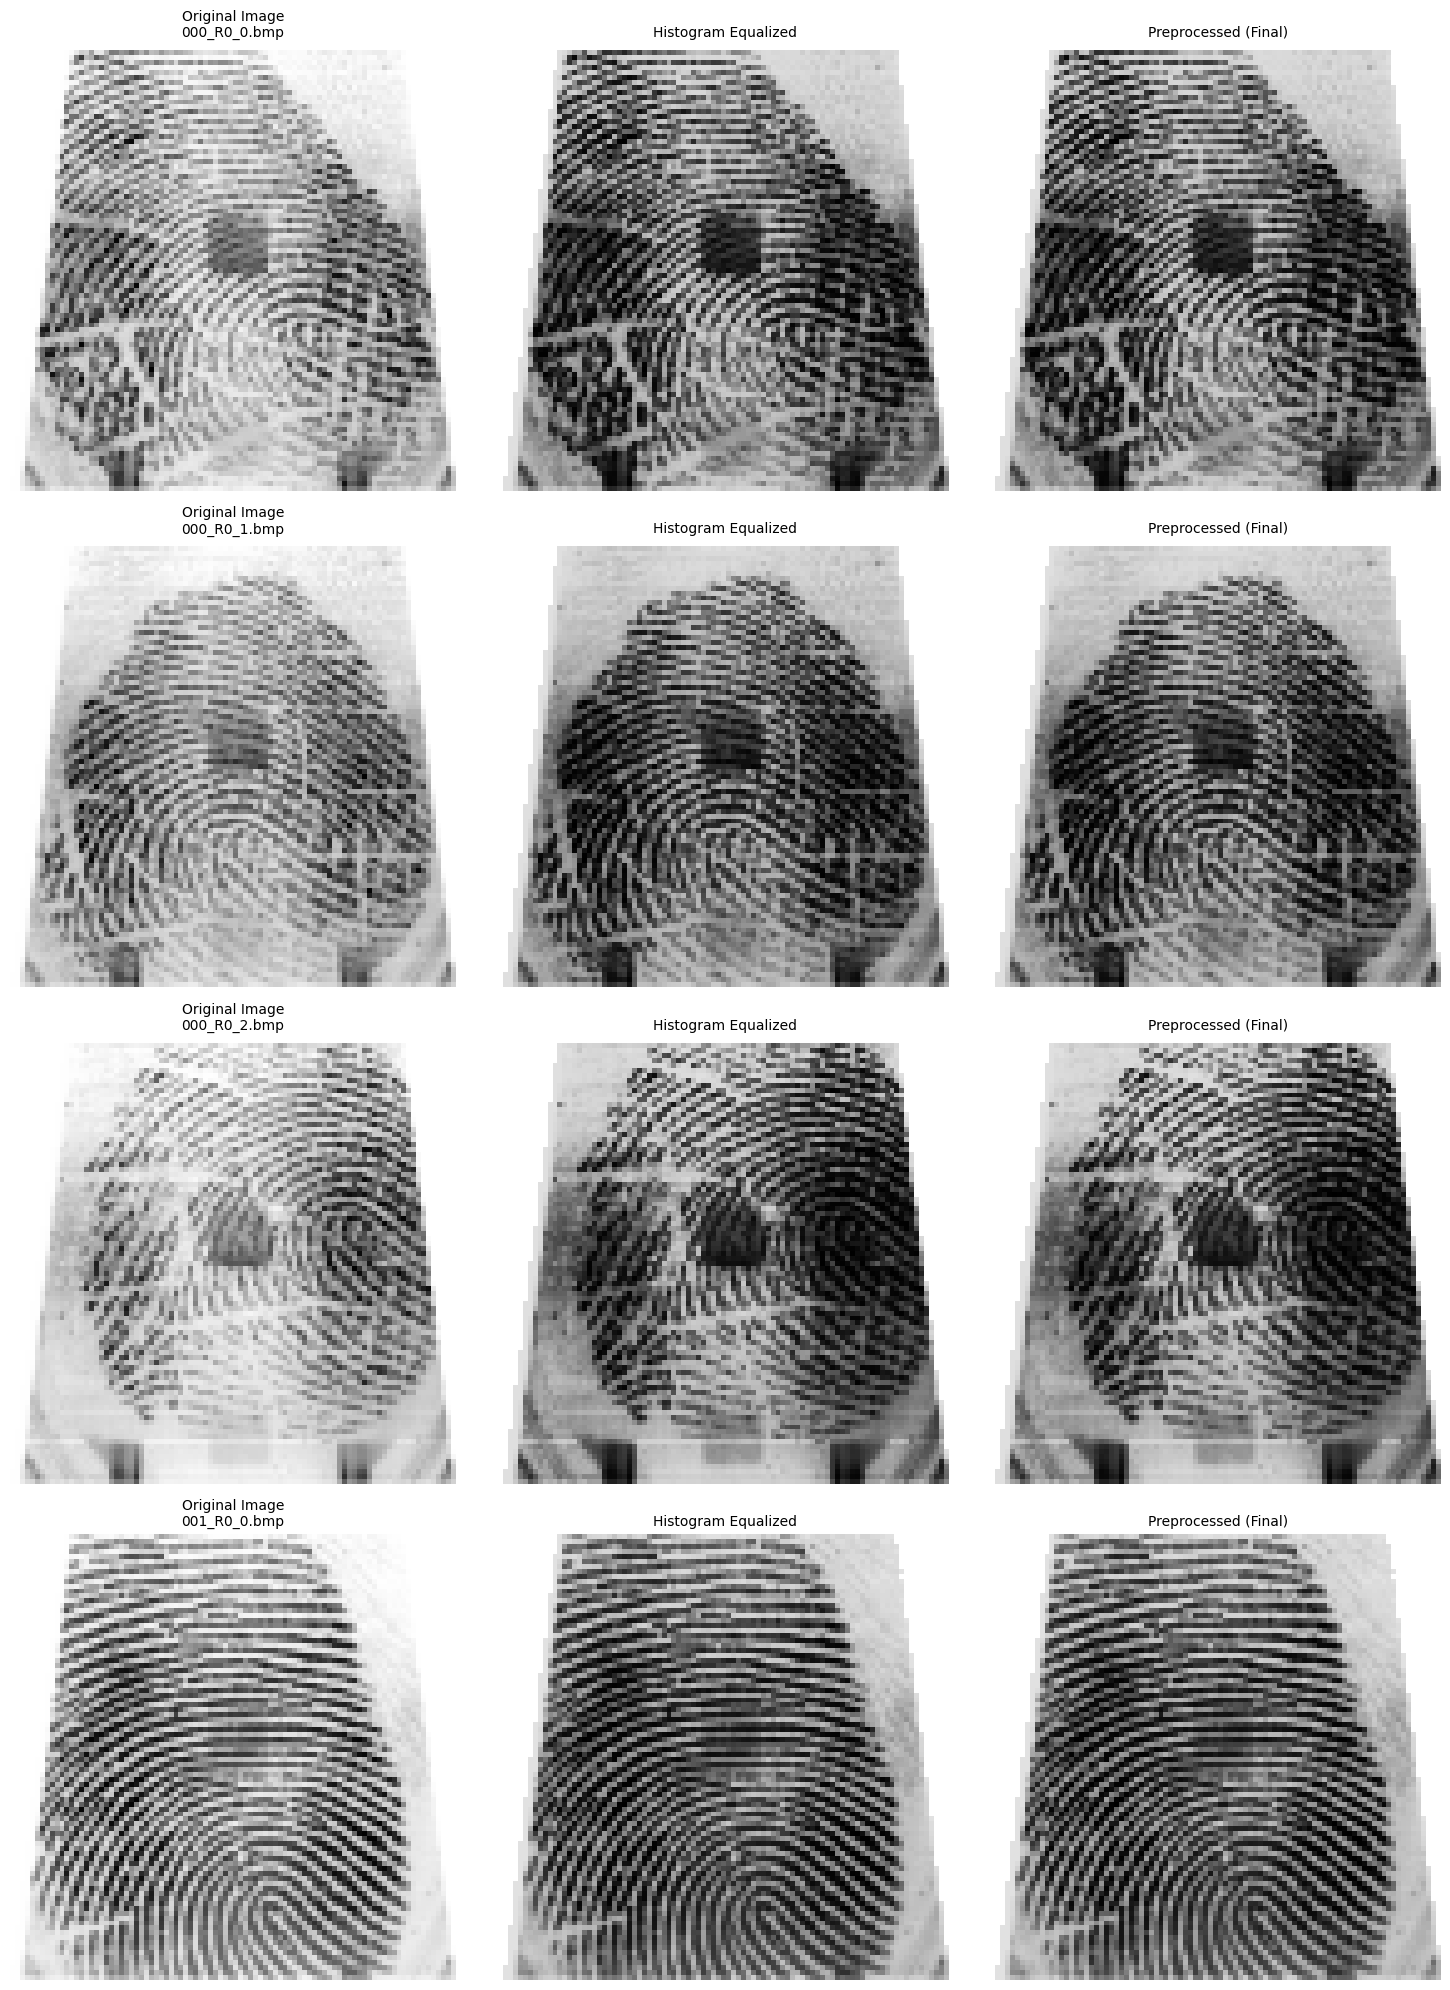


Preprocessing Statistics:
  Original image size: (356, 328)
  Processed size: (90, 90)
  Pixel value range: [0, 1] (float32)
  Histogram equalization: Applied
  Gaussian blur: Not applied


In [7]:
# ============================================
# Visualize Preprocessing Effects Comparison
# ============================================
# Display comparison between original and preprocessed images

import matplotlib.pyplot as plt

def visualize_preprocessing_effects(source_dir='Project-Data', output_dir='Project-Data-Processed', 
                                    num_samples=4):
    """
    Visualize preprocessing effects
    
    Parameters:
        source_dir: Source data directory
        output_dir: Processed data directory
        num_samples: Number of samples to display
    """
    # Randomly select a few samples from training set
    train_source = os.path.join(source_dir, 'train')
    train_output = os.path.join(output_dir, 'train')
    
    if not os.path.exists(train_source) or not os.path.exists(train_output):
        print("Error: Source or output directory does not exist")
        return
    
    # Get image file list
    source_files = sorted(glob.glob(os.path.join(train_source, '*.bmp')))[:num_samples]
    
    if len(source_files) == 0:
        print("Error: No image files found")
        return
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i, source_file in enumerate(source_files):
        filename = os.path.basename(source_file)
        
        # Read original image
        img_original = cv2.imread(source_file, cv2.IMREAD_GRAYSCALE)
        img_original_resized = cv2.resize(img_original, TARGET_SIZE, interpolation=cv2.INTER_AREA)
        
        # Read processed image
        if NORMALIZE_PIXELS:
            output_file = os.path.join(train_output, filename.replace('.bmp', '.npy'))
            if os.path.exists(output_file):
                img_processed = np.load(output_file)
                # Convert [0,1] range back to [0,255] for display
                img_processed_display = (img_processed * 255).astype(np.uint8)
            else:
                img_processed_display = None
        else:
            output_file = os.path.join(train_output, filename)
            if os.path.exists(output_file):
                img_processed_display = cv2.imread(output_file, cv2.IMREAD_GRAYSCALE)
            else:
                img_processed_display = None
        
        # Apply histogram equalization (for comparison)
        img_hist_eq = cv2.equalizeHist(img_original_resized)
        
        # Display original image
        axes[i, 0].imshow(img_original_resized, cmap='gray')
        axes[i, 0].set_title(f'Original Image\n{filename}', fontsize=10)
        axes[i, 0].axis('off')
        
        # Display histogram equalized image
        axes[i, 1].imshow(img_hist_eq, cmap='gray')
        axes[i, 1].set_title('Histogram Equalized', fontsize=10)
        axes[i, 1].axis('off')
        
        # Display final processed image
        if img_processed_display is not None:
            axes[i, 2].imshow(img_processed_display, cmap='gray')
            axes[i, 2].set_title('Preprocessed (Final)', fontsize=10)
        else:
            axes[i, 2].text(0.5, 0.5, 'Processed image not found', 
                          ha='center', va='center', transform=axes[i, 2].transAxes)
            axes[i, 2].set_title('Preprocessed (Not Found)', fontsize=10)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display statistics
    print("\nPreprocessing Statistics:")
    print(f"  Original image size: {img_original.shape}")
    print(f"  Processed size: {TARGET_SIZE}")
    print(f"  Pixel value range: {'[0, 1] (float32)' if NORMALIZE_PIXELS else '[0, 255] (uint8)'}")
    print(f"  Histogram equalization: {'Applied' if APPLY_HISTOGRAM_EQ else 'Not applied'}")
    print(f"  Gaussian blur: {'Applied' if APPLY_GAUSSIAN_BLUR else 'Not applied'}")

# Run visualization
visualize_preprocessing_effects()


In [ ]:
# ============================================
# Verify Processed Data
# ============================================
# Check if processed data is correctly saved

def verify_processed_data(output_dir='Project-Data-Processed'):
    """
    Verify processed data
    
    Parameters:
        output_dir: Processed data directory
    """
    print("Verifying processed data...")
    print("="*60)
    
    for subfolder in ['train', 'validate', 'test']:
        folder_path = os.path.join(output_dir, subfolder)
        if not os.path.exists(folder_path):
            print(f"\n{subfolder}: Directory does not exist")
            continue
        
        if NORMALIZE_PIXELS:
            # Check .npy files
            npy_files = glob.glob(os.path.join(folder_path, '*.npy'))
            print(f"\n{subfolder}:")
            print(f"  Found {len(npy_files)} .npy files")
            
            if len(npy_files) > 0:
                # Check first file
                sample_file = npy_files[0]
                sample_data = np.load(sample_file)
                print(f"  Sample file: {os.path.basename(sample_file)}")
                print(f"  Data shape: {sample_data.shape}")
                print(f"  Data type: {sample_data.dtype}")
                print(f"  Pixel value range: [{sample_data.min():.4f}, {sample_data.max():.4f}]")
        else:
            # Check .bmp files
            bmp_files = glob.glob(os.path.join(folder_path, '*.bmp'))
            print(f"\n{subfolder}:")
            print(f"  Found {len(bmp_files)} .bmp files")
            
            if len(bmp_files) > 0:
                # Check first file
                sample_file = bmp_files[0]
                sample_data = cv2.imread(sample_file, cv2.IMREAD_GRAYSCALE)
                print(f"  Sample file: {os.path.basename(sample_file)}")
                print(f"  Data shape: {sample_data.shape}")
                print(f"  Data type: {sample_data.dtype}")
                print(f"  Pixel value range: [{sample_data.min()}, {sample_data.max()}]")
    
    print("\n" + "="*60)
    print("Verification Complete!")

# Run verification
verify_processed_data()


验证处理后的数据...

train:
  找到 1464 个 .npy 文件
  样本文件: 422_R0_1.npy
  数据形状: (90, 90)
  数据类型: float32
  像素值范围: [0.0000, 1.0000]

validate:
  找到 500 个 .npy 文件
  样本文件: 324_R0_3.npy
  数据形状: (90, 90)
  数据类型: float32
  像素值范围: [0.0000, 1.0000]

test:
  找到 500 个 .npy 文件
  样本文件: 297_R0_4.npy
  数据形状: (90, 90)
  数据类型: float32
  像素值范围: [0.0000, 1.0000]

验证完成！
